In [ ]:
# импортируем все необходимые библиотеки
import pandas as pd
from sqlalchemy import create_engine, text
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import configparser

In [ ]:
config = configparser.ConfigParser()
# BASE_DIRECT = os.path.dirname(os.path.abspath(__file__))
# PARENT_DIR = os.path.dirname(BASE_DIRECT)
# config_path = os.path.join(PARENT_DIR, "config.ini")
# config = configparser.ConfigParser()
# config.read(config_path)
config.read("config.ini")
db_params = {
    'database': config['database'].get('databname'),
    'user': config['database'].get('user'),
    'password': config['database'].get('password'),
    'host': config['database'].get('host'),
    'port': config['database'].get('port')
}

# Формируем строку подключения с использованием f-строки
engine = create_engine(
    f"postgresql://{db_params['user']}:{db_params['password']}@"
    f"{db_params['host']}:{db_params['port']}/{db_params['database']}"
)
conn = engine.connect()

In [ ]:

try:
    # SQL-запрос
    ds = pd.read_sql_query(
    sql=text("SELECT * FROM sale_market WHERE EXTRACT(YEAR FROM purchase_datetime) = 2023"),
    con=engine
)
finally:
    conn.close()


Данные о продаже за 2023 год

In [ ]:
# Обогощение данных необходимыми столбцами
# Расчет итоговой стоимости чека с учетом скидок
# Создаем новый столбец check_total_pr, который представляет собой расчет итоговой стоимости позиции
# с учетом количества товара, цены за единицу и скидки за единицу
ds['check_total_pr'] = (ds['quantity']*ds['price_per_item']) - (ds['quantity']*ds['discount_per_item'])

# Проверка на наличие значений
# Создаем булевый столбец bool, который проверяет наличие значений в check_total_pr (проверка на NaN)
ds['bool'] = ds['check_total_pr'] == ds['check_total_pr']

# Преобразование даты
# Конвертируем столбец purchase_datetime в формат даты и времени
ds['purchase_datetime'] = pd.to_datetime(ds['purchase_datetime'], format='%Y-%m-%d')

# Расчет доли скидки
# Создаем столбец per_disc, показывающий долю скидки относительно цены за единицу товара
ds['per_disc'] = ds['discount_per_item'] / ds['price_per_item']

# Извлечение даты и месяца
# Создаем два новых столбца:
# date - содержит только дату
# month - содержит только месяц
ds['date'] = ds['purchase_datetime'].dt.date
ds['month'] = ds['purchase_datetime'].dt.month

# Расчет и округление доли скидки
# Создаем столбец discount_share, показывающий долю скидки относительно цены
ds['discount_share'] = round(ds['discount_per_item'] / ds['price_per_item'], 2)
ds

,client_id,gender,purchase_datetime,purchase_time_as_seconds_from_midnight,product_id,quantity,price_per_item,discount_per_item,total_price,check_total_pr,bool,per_disc,date,month,discount_share
0,516064,M,2023-01-19,69622,33365,32,3910.0,3752.0,5056.0,5056.0,True,0.959591,2023-01-19,1,0.96
1,177650,F,2023-01-20,6787,37078,2,473.0,444.0,58.0,58.0,True,0.938689,2023-01-20,1,0.94
2,95595,F,2023-01-20,28604,35108,62,4715.0,4627.0,5456.0,5456.0,True,0.981336,2023-01-20,1,0.98
3,366257,F,2023-01-20,62880,30957,0,99089.0,619.0,0.0,0.0,True,0.006247,2023-01-20,1,0.01
4,952764,M,2023-01-20,64974,27287,8,4887.0,3825.0,8496.0,8496.0,True,0.782689,2023-01-20,1,0.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039874,515817,F,2023-12-31,44975,46775,50,60193.0,42338.0,892750.0,892750.0,True,0.703371,2023-12-31,12,0.70
2039875,94923,M,2023-12-31,46100,25087,34,76346.0,41171.0,1195950.0,1195950.0,True,0.539269,2023-12-31,12,0.54
2039876,862697,M,2023-12-31,46208,46394,3,60347.0,40916.0,58293.0,58293.0,True,0.678012,2023-12-31,12,0.68
2039877,54779,M,2023-12-31,9097,18624,16,40305.0,18747.0,344928.0,344928.0,True,0.465128,2023-12-31,12,0.47


In [ ]:
count_sku = ds.groupby('product_id')['product_id'].nunique().count()
Tran_row = ds['client_id'].count()
quantityDay_mean = (ds.groupby('purchase_datetime').agg({'quantity':'sum'})).mean().mean()
sumDay_mean = (ds.groupby('purchase_datetime').agg({'total_price':'sum'})).mean().mean()
sum_profit = ds['total_price'].sum()
sum_rev = (ds['quantity']*ds['price_per_item']).sum()
disc = sum_profit/sum_rev
mean_profit = (ds['product_id'].agg({'total_price':'mean'})).mean()
sumDay_mean

np.float64(4587852010.539726)

In [ ]:
# Группировка данных по product_id и расчет общей выручки
revenue_prod = ds.groupby('product_id').agg(
    tot_rev=('total_price','sum')  # Суммируем total_price для каждого продукта
).reset_index().sort_values('tot_rev',ascending=False)

# Добавляем кумулятивную сумму выручки
revenue_prod['cumsum'] = revenue_prod['tot_rev'].cumsum()

# Рассчитываем долю кумулятивной суммы в процентах
revenue_prod['cumsum%'] = revenue_prod['cumsum']*100/revenue_prod['tot_rev'].sum()

# Классифицируем продукты по категориям ABC
revenue_prod['ABC'] = revenue_prod['cumsum%'].apply(
    lambda x: "A" if x<=80 else "B" if x<=95 else "С"
)

# Подсчитываем количество продуктов в каждой категории ABC
r = revenue_prod['ABC'].value_counts().reset_index()
r['totc'] = revenue_prod['ABC'].count()  # Общее количество продуктов
r['%'] = r['count']*100/r['totc']  # Процентное соотношение категорий

# Добавляем порядковый номер строки
revenue_prod['row_number'] = range(1, len(revenue_prod) + 1)

# Рассчитываем процентное соотношение позиций в общем списке
revenue_prod['prod%'] = revenue_prod['row_number']*100/revenue_prod['row_number'].count()
revenue_prod

,product_id,tot_rev,cumsum,cumsum%,ABC,row_number,prod%
37181,37181,126506926.0,1.265069e+08,0.007555,A,1,0.002
30239,30239,122577085.0,2.490840e+08,0.014875,A,2,0.004
22406,22406,122007891.0,3.710919e+08,0.022160,A,3,0.006
10292,10292,121115031.0,4.922069e+08,0.029393,A,4,0.008
45018,45018,118322228.0,6.105292e+08,0.036459,A,5,0.010
...,...,...,...,...,...,...,...
35351,35351,4154.0,1.674566e+12,100.000000,С,49996,99.992
22981,22981,3960.0,1.674566e+12,100.000000,С,49997,99.994
25894,25894,1792.0,1.674566e+12,100.000000,С,49998,99.996
38944,38944,1453.0,1.674566e+12,100.000000,С,49999,99.998


In [ ]:
revenue_prod['ABC'].value_counts()

,count
ABC,
A,26996
B,11509
С,11495


In [ ]:
revenue_prodABC = pd.DataFrame({
    'absolute': revenue_prod['ABC'].value_counts(),           # абсолютные числа
    'proportion': revenue_prod['ABC'].value_counts(normalize=True)  # доли (от 0 до 1)
}).reset_index()
revenue_prodABC

,ABC,absolute,proportion
0,A,26996,0.53992
1,B,11509,0.23018
2,С,11495,0.22990


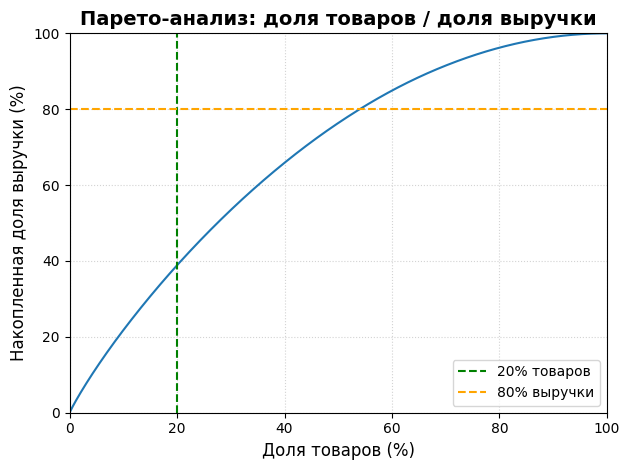

In [ ]:
sns.lineplot(
    y=revenue_prod['cumsum%'],
    x=revenue_prod['prod%'],
)
# Добавляем вертикальные и горизонтальные линии
plt.axvline(20, linestyle='--', color='green', label='20% товаров')
plt.axhline(80, linestyle='--', color='orange', label='80% выручки')

# Оформляем заголовок и оси
plt.title('Парето-анализ: доля товаров / доля выручки', fontsize=14, fontweight='bold')
plt.xlabel('Доля товаров (%)', fontsize=12)
plt.ylabel('Накопленная доля выручки (%)', fontsize=12)

# Добавляем сетку и легенду
plt.grid(True, linestyle=':', color='lightgray')
plt.legend(fontsize=10)

# Добавляем подписи значений

# Настраиваем пределы осей
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()


In [ ]:
#Группирова продаж по продуктам в разрезе месяцев
ds.groupby(['product_id','month']).agg(m_count=('quantity','sum')).reset_index().pivot(index='product_id',columns='month',values='m_count').reset_index().fillna(0)

month,product_id,1,2,3,4,5,6,7,8,9,10,11,12
0,0,28.0,73.0,123.0,136.0,145.0,361.0,79.0,141.0,218.0,0.0,0.0,10.0
1,1,82.0,67.0,166.0,223.0,99.0,90.0,41.0,137.0,209.0,212.0,27.0,22.0
2,2,45.0,133.0,132.0,195.0,291.0,67.0,365.0,178.0,57.0,54.0,141.0,372.0
3,3,18.0,24.0,33.0,110.0,96.0,22.0,83.0,125.0,85.0,120.0,50.0,204.0
4,4,42.0,10.0,160.0,246.0,94.0,165.0,0.0,19.0,157.0,81.0,73.0,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,1.0,38.0,20.0,92.0,207.0,34.0,239.0,11.0,88.0,50.0,132.0,151.0
49996,49996,58.0,0.0,48.0,87.0,79.0,73.0,86.0,61.0,326.0,71.0,41.0,237.0
49997,49997,95.0,233.0,77.0,322.0,42.0,138.0,100.0,188.0,0.0,80.0,10.0,107.0
49998,49998,145.0,75.0,179.0,73.0,196.0,58.0,24.0,47.0,22.0,171.0,44.0,195.0


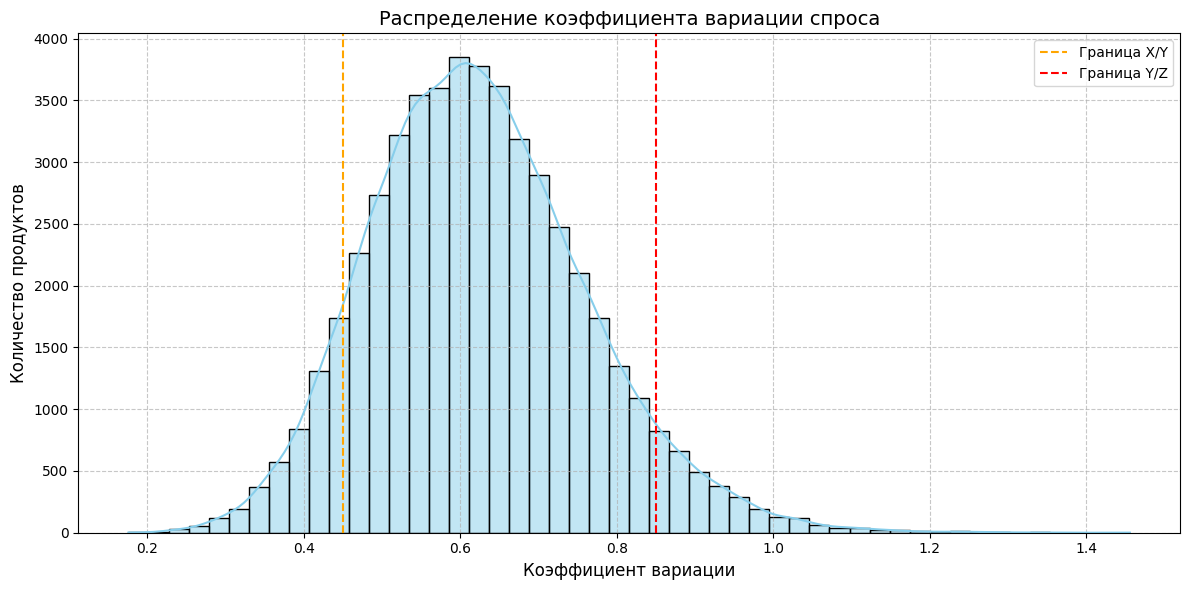

Распределение по категориям XYZ:
  xyz  absolute  proportion
0   Y     42293     0.84586
1   X      4687     0.09374
2   Z      3020     0.06040


In [ ]:
# Группировка данных по продукту и месяцу с агрегацией показателей
df2 = (
    ds
    .groupby(['product_id', 'month'])
    .agg(
        m_count=('quantity', 'sum'),  # Общее количество продаж за месяц
        avg_disc=('discount_share', 'mean')  # Средняя скидка
    )
    .reset_index()
)

# Анализ стабильности спроса по продуктам
df3 = (
    df2
    .groupby('product_id')
    .agg(
        avg=('m_count', 'mean'),  # Среднее количество продаж
        std=('m_count', 'std')  # Стандартное отклонение
    )
    .assign(
        cov=lambda x: x['std'] / x['avg'],  # Коэффициент вариации
        xyz=lambda x: pd.cut(
            x['cov'],
            bins=[0, 0.45, 0.85, float('inf')],
            labels=['X', 'Y', 'Z'],
            include_lowest=True
        )
    )
).reset_index()

# Анализ распределения по категориям XYZ
category_distribution = pd.DataFrame({
    'absolute': df3['xyz'].value_counts(),           # абсолютные числа
    'proportion': df3['xyz'].value_counts(normalize=True)  # доли (от 0 до 1)
}).reset_index()
# Визуализация распределения коэффициента вариации
plt.figure(figsize=(12, 6))
sns.histplot(
    df3['cov'],
    bins=50,
    kde=True,
    color='skyblue',
    edgecolor='black'
)

plt.title('Распределение коэффициента вариации спроса', fontsize=14)
plt.xlabel('Коэффициент вариации', fontsize=12)
plt.ylabel('Количество продуктов', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Добавление вертикальных линий для границ категорий
plt.axvline(0.45, color='orange', linestyle='--', label='Граница X/Y')
plt.axvline(0.85, color='red', linestyle='--', label='Граница Y/Z')
plt.legend()

plt.tight_layout()
plt.show()

# Вывод результатов категоризации
print("Распределение по категориям XYZ:")
print(category_distribution)

Проведённый анализ коэффициента вариации (CV) выявил следующее распределение ассортимента: ~10% товаров относятся к стабильной группе X (CV ≤ 0,45) со стабильным спросом, 85% составляют группу Y (0,45 < CV ≤ 0,85) с умеренной волатильностью, а 6% входят в группу Z (CV > 0,85) с высокой нестабильностью продаж; гистограмма подтверждает корректность границ сегментов с пиком в области CV = 0,6, что позволяет выстроить эффективную систему управления: автоматизированное планирование для группы X, адаптивное управление для доминирующей группы Y и индивидуальный подход к группе Z, обеспечивая оптимальный баланс между стабильными и волатильными позициями в ассортименте.

**Корреляция скидки и спроса**

In [ ]:
products_daily_sales = ds.groupby(['product_id', 'date'], as_index=False).agg(
    quantity_per_day=('quantity', 'sum'),
    discount_share_per_day=('discount_share', 'mean')
    )
products_daily_sales.head()

,product_id,date,quantity_per_day,discount_share_per_day
0,0,2023-01-23,28,0.86
1,0,2023-02-18,45,0.35
2,0,2023-02-24,28,0.24
3,0,2023-03-01,9,0.43
4,0,2023-03-04,4,0.60


In [ ]:
disc_correlation = (
    products_daily_sales.groupby('product_id', group_keys=False)
    .apply(
        lambda sales: (
            np.nan if sales.shape[0] < 15 else
            np.nan if sales['discount_share_per_day'].nunique() < 1 else
            sales['quantity_per_day'].corr(sales['discount_share_per_day'])
        ),
        include_groups=False
    )
    .reset_index(name='discount_correlation')
)

disc_correlation.head()

,product_id,discount_correlation
0,0,-0.060620
1,1,-0.043284
2,2,0.005819
3,3,0.243175
4,4,-0.137624


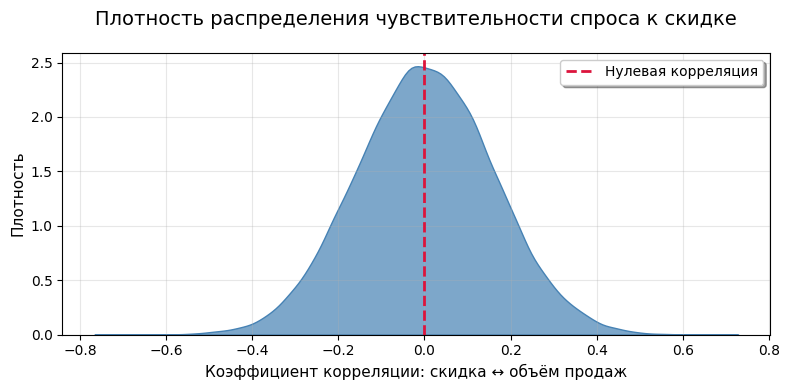

In [ ]:
plt.figure(figsize=(8, 4))
sns.kdeplot(data=disc_correlation,
             x='discount_correlation',
             fill=True,
             color='steelblue',
             alpha=0.7)

plt.axvline(x=0, color='crimson', linestyle='--', linewidth=2, label='Нулевая корреляция')
plt.title('Плотность распределения чувствительности спроса к скидке', fontsize=14, pad=20)
plt.xlabel('Коэффициент корреляции: скидка ↔ объём продаж', fontsize=11)
plt.ylabel('Плотность', fontsize=11)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Результаты анализа показывают:

для основной массы товаров скидки практически не влияют на спрос (корреляция ≈ 0);

лишь отдельные позиции заметно реагируют на изменение скидки (сильная +/− корреляция).

Вывод: эффективнее отказаться от массовых скидок в пользу точечных акций по чувствительным товарам.

In [ ]:
results = revenue_prod[['product_id', 'ABC']].merge(df3[['product_id', 'xyz']], on='product_id', how='left')
results['ABC_XYZ'] = results['ABC'].astype(str) + results['xyz'].astype(str)
results = results.merge(disc_correlation[['product_id', 'discount_correlation']], on='product_id', how='left')
results.head()

,product_id,ABC,xyz,ABC_XYZ,discount_correlation
0,37181,A,Y,AY,-0.088758
1,30239,A,Y,AY,-0.087953
2,22406,A,Y,AY,-0.336550
3,10292,A,Y,AY,0.169351
4,45018,A,Y,AY,0.068212


In [ ]:
#Ниже — Итоговый датафрейма с результатами ABC, XYZ‑анализов и объединёнными группами.

In [ ]:
results['ABC_XYZ'].value_counts(normalize=True) * 100
category_ABC_XYZ = pd.DataFrame({
    'absolute': results['ABC_XYZ'].value_counts(),           # абсолютные числа
    'proportion': results['ABC_XYZ'].value_counts(normalize=True)  # доли (от 0 до 1)
}).reset_index()
category_ABC_XYZ

,ABC_XYZ,absolute,proportion
0,AY,22842,0.45684
1,BY,9750,0.19500
2,СY,9701,0.19402
3,AX,2703,0.05406
4,AZ,1451,0.02902
5,СX,1012,0.02024
6,BX,972,0.01944
7,BZ,787,0.01574
8,СZ,782,0.01564


In [ ]:
ABC_XYZ_Disc = results.groupby('ABC_XYZ')['discount_correlation'].mean().sort_values().reset_index()
results.groupby('ABC_XYZ')['discount_correlation'].mean().sort_values()
ABC_XYZ_Disc


,ABC_XYZ,discount_correlation
0,AZ,-0.008980
1,AY,-0.008508
2,AX,-0.006142
3,BZ,0.007987
4,BY,0.009775
5,BX,0.012407
6,СZ,0.013657
7,СY,0.013962
8,СX,0.018179


In [ ]:

result = category_ABC_XYZ.merge(ABC_XYZ_Disc, how='left', on='ABC_XYZ')
result

,ABC_XYZ,absolute,proportion,discount_correlation
0,AY,22842,0.45684,-0.008508
1,BY,9750,0.19500,0.009775
2,СY,9701,0.19402,0.013962
3,AX,2703,0.05406,-0.006142
4,AZ,1451,0.02902,-0.008980
5,СX,1012,0.02024,0.018179
6,BX,972,0.01944,0.012407
7,BZ,787,0.01574,0.007987
8,СZ,782,0.01564,0.013657


/tmp/ipython-input-559914324.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


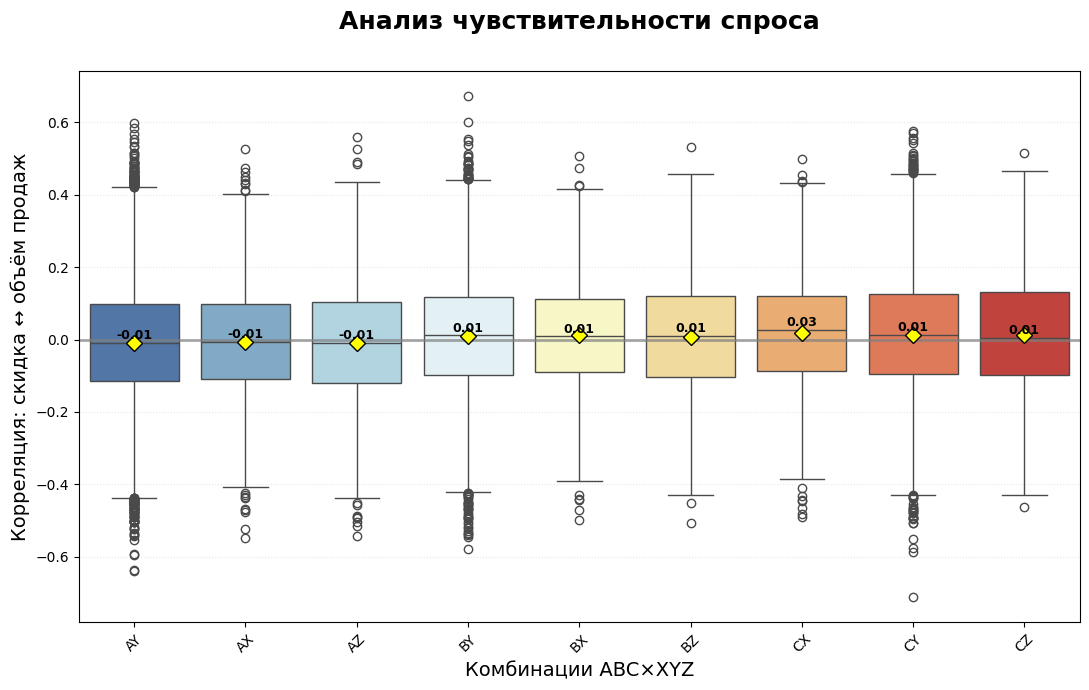

In [ ]:
ig, ax = plt.subplots(figsize=(11, 7))

sns.boxplot(
    data=results,
    x='ABC_XYZ',
    y='discount_correlation',
    ax=ax,
    palette='RdYlBu_r',
    showmeans=True,
    meanprops={"marker": "D", "markerfacecolor": "yellow", "markeredgecolor": "black", "markersize": 8}
)

ax.set_title('Анализ чувствительности спроса', fontsize=18, pad=30, weight='bold')
ax.set_xlabel('Комбинации ABC×XYZ', fontsize=14)
ax.set_ylabel('Корреляция: скидка ↔ объём продаж', fontsize=14)


ax.axhline(y=0, color='gray', linestyle='-', linewidth=2, alpha=0.7)
ax.grid(axis='y', alpha=0.3, linestyle=':')


# Подписи медиан
for i, group in enumerate(results['ABC_XYZ'].unique()):
    median = results[results['ABC_XYZ'] == group]['discount_correlation'].median()
    ax.text(i, median + 0.01, f'{median:.2f}',
             horizontalalignment='center', fontweight='bold', fontsize=9)


plt.setp(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()